# Analyse des décès covid par statut vaccinal 


## Résumé

Cette feuille de calcul [Jupyter](https://jupyter.org/) analyse les données de décès de la DREES, par statut vaccinal et par âge, et tente d'évaluer les décès évités par la vaccination, et ceux qui auraient pu l'être avec une couverture vaccinale complète.


## Données

Les données proviennent du site de la DREES. Elle comportent les décès depuis juin 2021, par statut vaccinal, dat et tranche d'âge

https://data.drees.solidarites-sante.gouv.fr/explore/dataset/covid-19-resultats-par-age-issus-des-appariements-entre-si-vic-si-dep-et-vac-si/information/

## Méthodologie 

Pour chaque tranche d'âge, chaque statut vaccinal et chaque date, la DREES fournit les effectifs du groupe correspondant (age et statut vaccinal), à date. Ceci permet de calculer une mortalité journalière pour chaque sous groupe.

Il est alors possible de simuler des scénarios de couverture vaccinale (0% et 100%) appliquant la mortalité d'un sous groupe à l'autre, pour une même tranche d'âge.

## Limitations

Ces calculs reposent sur l'hypothèse que la différence de mortalité des groupes vaccinés et non-vaccinés dépend essentiellement de leur statut vaccinal. Le facteur de confusion "âge" est pris en compte par la strafification par âge déjà appliquée par la DREES. 

D'autres facteurs de confusion peuvent néamoins subsister:

* **Comorbidités** : Chez les plus jeunes surtout (0-19 ans), les individus présentant des comorbidités ont été vaccinés en priorité. L'ignorance de cette corrélation tend à sous estimer l'impact positif de la vaccination.

* **Classes sociales** : Les classes populaires sont à la fois moins plus vulnérables et moins vaccinées que le reste de la population. [1](https://www.cdc.gov/mmwr/volumes/70/wr/mm7022e1.htm) [2](https://www.huffingtonpost.fr/entry/vaccination-la-richesse-ou-les-diplomes-insuffisants-pour-expliquer-le-choix-de-ceux-qui-decident-de-ne-pas-le-faire_fr_61166e34e4b07c1403142492). L'ignorance de cette corrélation tend à surestimer l'impact positif de la vaccination.

* **Transmission** : Cette étude ne considère pas l'effet de la vaccination sur la transmission ([évalué à 40% environ](https://www.france24.com/en/live-news/20211124-vaccines-reduce-covid-transmission-by-40-who)). L'ignorance de cet tend à sous estimer l'impact positif de la vaccination.

# Code 

Le code est disponible sur Github :
https://github.com/bpresles/drees-deces


# Auteur

Raphaël Jolivet : https://mamot.fr/@RaphJ

Bertrand Presles : bertrand@presles.fr


# Licence

Cette feuille de calcul est distribuée sous [licence CC-By](https://creativecommons.org/licenses/by/4.0/)



# Initialisation

In [1]:
# Import de librairies
import pandas as pd
import matplotlib.pyplot as plt

# Taille par défaut des graphes
plt.rc('figure', figsize=(13,10))
plt.rcParams.update({
    "figure.facecolor":  (1.0, 1.0, 1.0, 0.0), 
    "savefig.facecolor": (1.0, 1.0, 1.0, 0.0), 
})
plt.rcParams["font.size"]=12

# Chargement des données

In [2]:
data = pd.read_csv("drees-covid-age.csv", sep=";", parse_dates=["date"]) \
    .fillna(0)
data.tail()

,date,vac_statut,age,nb_PCR,nb_PCR_sympt,nb_PCR+_sympt,nb_PCR+,HC,HC_PCR+,SC,SC_PCR+,DC,DC_PCR+,effectif,PCR+_pourcent_omicron,PCR+_sympt_pourcent_omicron,HC_pourcent_omicron,SC_pourcent_omicron
9062,2022-01-09,Complet de moins de 3 mois - sans rappel,[80;+],283.09,43.66,10.62,32.72,14.91,12.29,0.56,0.50,1.03,1.00,100068.30,96.84,100.00,100.00,0.0
9063,2022-01-09,Complet entre 3 mois et 6 mois - sans rappel,[80;+],653.77,96.07,31.40,89.67,40.23,31.07,0.56,0.47,11.57,10.35,261650.10,88.46,87.11,100.00,0.0
9064,2022-01-09,Complet de 6 mois et plus - sans rappel,[80;+],632.44,78.94,21.72,101.45,48.49,39.67,3.26,3.14,20.18,16.97,289533.56,81.77,55.91,82.24,0.0
9065,2022-01-09,Complet de moins de 3 mois - avec rappel,[80;+],18.19,2.42,0.05,1.16,0.22,0.17,0.00,0.00,0.00,0.00,12705.21,0.00,0.00,0.00,0.0
9066,2022-01-09,Complet entre 3 mois et 6 mois - avec rappel,[80;+],188.02,23.49,4.69,16.17,4.16,3.43,0.01,0.00,0.00,0.00,91811.55,100.00,100.00,100.00,0.0


# Pivot par statut vaccinal et aggrégation 

On pivote les données pour avoir une colonne par statut vaccinal.
Les statuts vaccinaux sont ensuite groupés :
* Les 6 sous groupes "complet" => "vax"
* Les non vaccinés et vaccinés une dose seulement => "non vax"

In [3]:
# Pivot par statut vaccinal, pour les décès et les effectifs
dc = data.pivot(index=["age", 'date'], columns='vac_statut', values="DC").fillna(0)
eff = data.pivot(index=["age", 'date'], columns='vac_statut', values="effectif").fillna(0)

In [4]:
def vax_nvax(df) :
    """Aggrège les vax et non-vax"""

    # Liste des 6 colonnes Complet et Primo dose efficace...
    cols_complet = [col for col in df.columns if 'Complet' in col]

    # On crée une colonne "vax" somme des 6 complet et primo dose efficace
    df["vax"] = sum(df[col] for col in cols_complet)
    
    # Les non vaccinés sont ceux n'ayant reçu aucune dose ou 1 dose récente (avant qu'elle soit efficace)
    df["non_vax"] = df["Non-vaccinés"] + df["Primo dose récente"] + df["Primo dose efficace"]
    
    return df[["non_vax", "vax"]]

In [5]:
dc = vax_nvax(dc)

In [6]:
eff = vax_nvax(eff)

# Ratios  & scénarios

On aggrège les tableaux de décès et d'effectifs et on calcule les ratios :
 * **ratio_vax** = dc_vax / effectif_vax
 * **ratio_non_vax** = dc_non_vax / effectif_non_vax
 * **dc_vax_1m** = ratio_vax * 1000000
 * **dc_non_vax_1m** = ratio_non_vax * 1000000
 * **dc_0** (hypothèse 0% vax) = dc_non_vax + ratio_non_vax * effectif_vax
 * **dc_100** (hypothèse 100% vax) = dc_vax + ratio_vax * effectif_non_vax
 * **dc_evites** = dc_0 - (dc_vax + dc_non_vax)
 * **dc_evitables** = (dc_vax + dc_non_vax) - dc_100

In [7]:
# Aggregate two dataframes
dc["eff_vax"] = eff["vax"]
dc["eff_non_vax"] = eff["non_vax"]

In [8]:
# Ratio DC / effectif for each group
dc["ratio_vax"] = (dc["vax"] / eff["vax"])
dc["ratio_non_vax"] = (dc["non_vax"] / eff["non_vax"])

# DC for 1 million of each group
dc["dc_vax_1m"] = dc["ratio_vax"] * 1000000
dc["dc_non_vax_1m"] = dc["ratio_non_vax"] * 1000000

# If noone was vaccinated : 
# assume same death rate of vaccinated group
dc["dc_0"] = dc["non_vax"]  + dc["ratio_non_vax"] * eff["vax"]

# If everyone was vaccinated
# assume same death rate for unvaccinated group
dc["dc_100"] = dc["vax"] + dc["ratio_vax"] * eff["non_vax"]

In [9]:
# Sum dataframe
somme = dc.groupby(level=0).sum()
somme = somme[["non_vax", "vax", "dc_0", "dc_100", "dc_vax_1m", "dc_non_vax_1m"]]

# Efficacite vaccinale
somme["eff_vax"] = 100 - 100 * somme["dc_vax_1m"] / (somme["dc_non_vax_1m"] + somme["dc_vax_1m"])
somme["dc_all"] = (somme.vax+somme.non_vax)
somme["saved"] = somme.dc_0 - somme.dc_all
somme["to_save"] = somme.dc_all - somme.dc_100

somme = somme.astype(int)

somme2 = somme.rename(columns={
    "non_vax" : "Décès chez les non-vaccinés", 
    "vax" : "Décès chez les vaccinés",
    "dc_0" : "Décès si 0% de la population est vaccinée", 
    "dc_100" : "Décès si 100% de la population est vaccinée",
    "dc_vax_1m": "Décès chez les vaccinés pour 1M d'individus",
    "dc_non_vax_1m": "Décès chez les non vaccinés pour 1M d'individus",
    "eff_vax": "Efficacité du vaccin (%)",
    "dc_all": "Décès au total",
    "saved": "Décès évités",
    "to_save": "Décès évitables"
})

somme2

vac_statut,Décès chez les non-vaccinés,Décès chez les vaccinés,Décès si 0% de la population est vaccinée,Décès si 100% de la population est vaccinée,Décès chez les vaccinés pour 1M d'individus,Décès chez les non vaccinés pour 1M d'individus,Efficacité du vaccin (%),Décès au total,Décès évités,Décès évitables
age,,,,,,,,,,
"[0,19]",18,4,24,12,0,1,66,22,2,9
"[20,39]",125,38,559,52,3,35,91,163,395,111
"[40,59]",796,315,4513,411,23,260,91,1111,3401,699
"[60,79]",3324,2365,23884,2737,198,1730,89,5689,18195,2951
[80;+],3971,3306,24066,3947,1031,6285,85,7277,16788,3330


# Graphes

## Décès par tranche d'âge et statut vaccinal

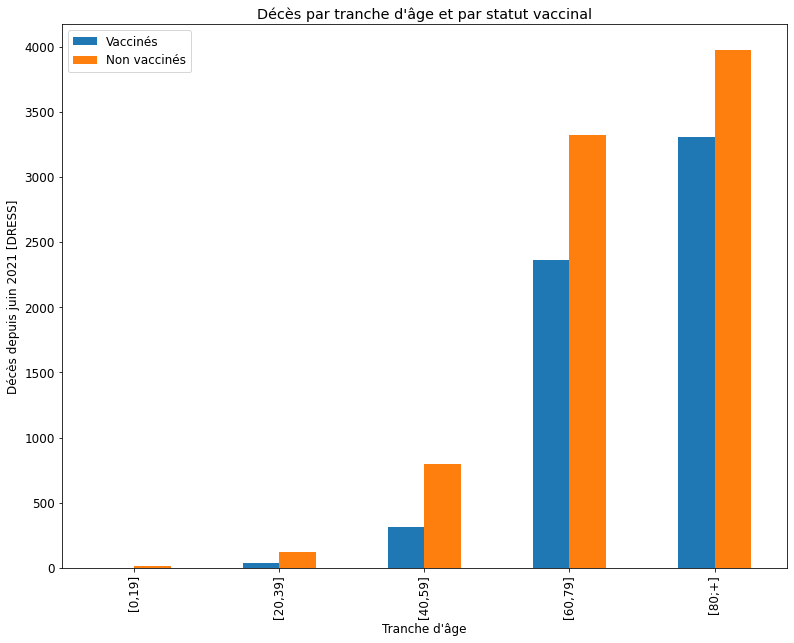

In [10]:
somme[["vax", "non_vax"]].plot.bar(
    title="Décès par tranche d'âge et par statut vaccinal",
    ylabel="Décès depuis juin 2021 [DRESS]",
    xlabel="Tranche d'âge")
plt.legend(["Vaccinés", "Non vaccinés"])

## Décès par tranche d'âge et statut vaccinal, normés pour 1 million d'individus

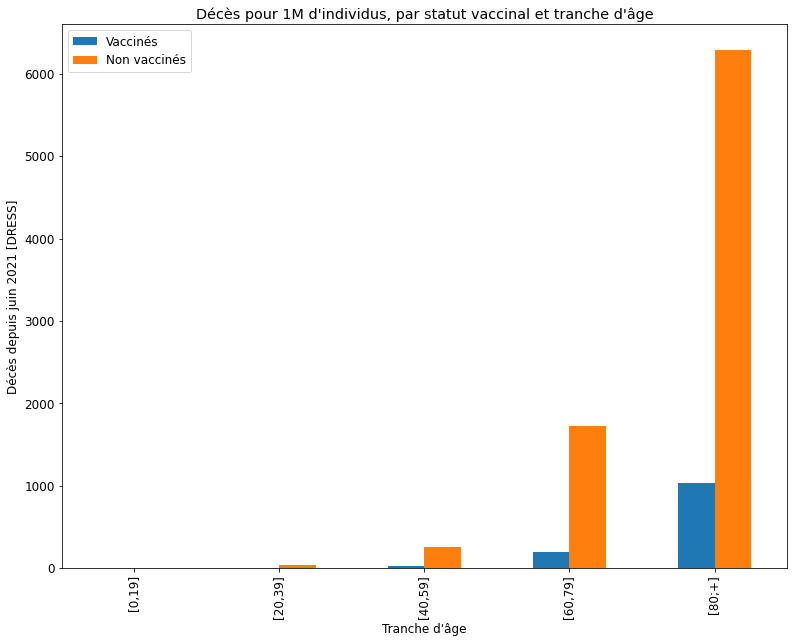

In [11]:
somme[["dc_vax_1m", "dc_non_vax_1m"]].plot.bar(
    title="Décès pour 1M d'individus, par statut vaccinal et tranche d'âge",
    ylabel="Décès depuis juin 2021 [DRESS]",
    xlabel="Tranche d'âge")
plt.legend(["Vaccinés", "Non vaccinés"])

## Comparaison des scenarios 0% et 100% vaccinés

### Série temporelle

In [12]:
# Somme des tranches d'age
serie = dc.groupby(level=1).sum().rolling("7D").mean()
serie["dc_tot"] = serie.vax + serie.non_vax
serie2 = serie.rename(columns={
    "non_vax" : "Décès chez les non-vaccinés", 
    "vax" : "Décès chez les vaccinés",
    "eff_vax": "Nombre de vaccinés",
    "eff_non_vax": "Nombre de non vaccinés",
    "ratio_vax": "Ratio nombre de décès / total chez les vaccinés",
    "ratio_non_vax": "Ratio nombre de décès / total chez les non vaccinés",
    "dc_0" : "Décès si 0% de la population est vaccinée", 
    "dc_100" : "Décès si 100% de la population est vaccinée",
    "dc_vax_1m": "Décès chez les vaccinés pour 1M d'individus",
    "dc_non_vax_1m": "Décès chez les non vaccinés pour 1M d'individus",
    "dc_tot": "Décès au total"
})
serie2.tail()

vac_statut,Décès chez les non-vaccinés,Décès chez les vaccinés,Nombre de vaccinés,Nombre de non vaccinés,Ratio nombre de décès / total chez les vaccinés,Ratio nombre de décès / total chez les non vaccinés,Décès chez les vaccinés pour 1M d'individus,Décès chez les non vaccinés pour 1M d'individus,Décès si 0% de la population est vaccinée,Décès si 100% de la population est vaccinée,Décès au total
date,,,,,,,,,,,
2022-01-05,101.491429,90.415714,5.103959e+07,1.575657e+07,0.000018,0.000149,18.217346,148.616096,908.737415,102.362135,191.907143
2022-01-06,102.838571,89.637143,5.106191e+07,1.573265e+07,0.000018,0.000152,18.336902,151.546784,919.836523,101.521159,192.475714
2022-01-07,103.131429,90.620000,5.108377e+07,1.570919e+07,0.000019,0.000150,18.586360,150.237920,927.602797,102.615330,193.751429
2022-01-08,99.942857,91.308571,5.110531e+07,1.568606e+07,0.000018,0.000143,18.382223,143.260916,903.243932,103.470775,191.251429
2022-01-09,102.712857,91.560000,5.112679e+07,1.566298e+07,0.000018,0.000149,18.255946,148.713944,921.888421,103.487249,194.272857


Text(0.5, 1.0, 'Comparaison des scénarios : réel (bleu) / sans vaccin (jaune) / 100% vaccin (vert)')

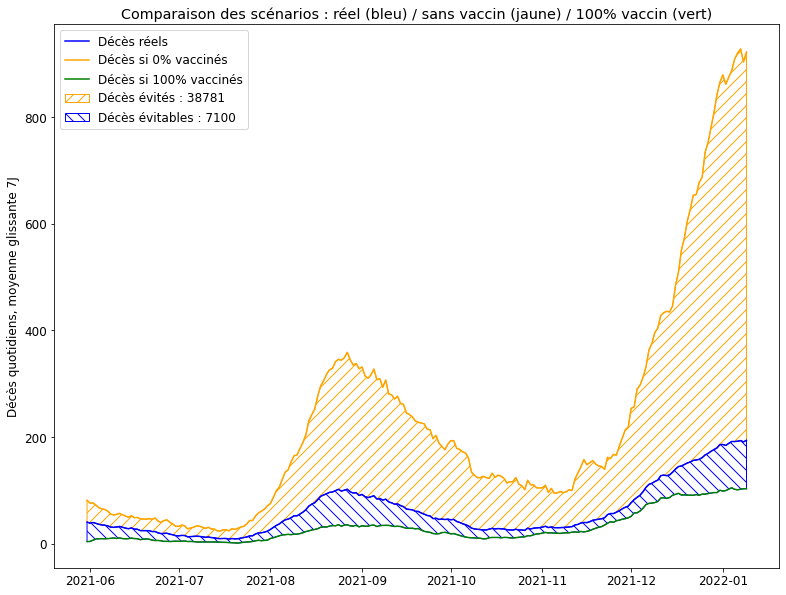

In [13]:
plt.ylabel("Décès quotidiens, moyenne glissante 7J")

plt.plot(serie.index, serie.dc_tot, label="Décès réels", color="blue")

plt.plot(serie.index, serie.dc_0, label="Décès si 0% vaccinés", color="orange")
plt.fill_between(
    serie.index, 
    serie.dc_tot, 
    serie.dc_0, 
    hatch="//", color="white",edgecolor="orange",
    label="Décès évités : " + str(somme.sum()["saved"]))

plt.plot(serie.index, serie.dc_100, label="Décès si 100% vaccinés", color="green")
plt.fill_between(
    serie.index, 
    serie.dc_tot, 
    serie.dc_100, 
    hatch='\\\\', color="white", edgecolor="blue",
    label="Décès évitables : " + str(somme.sum()["to_save"]))

plt.legend()
plt.title("Comparaison des scénarios : réel (bleu) / sans vaccin (jaune) / 100% vaccin (vert)")

### Bilan par tranche d'âge

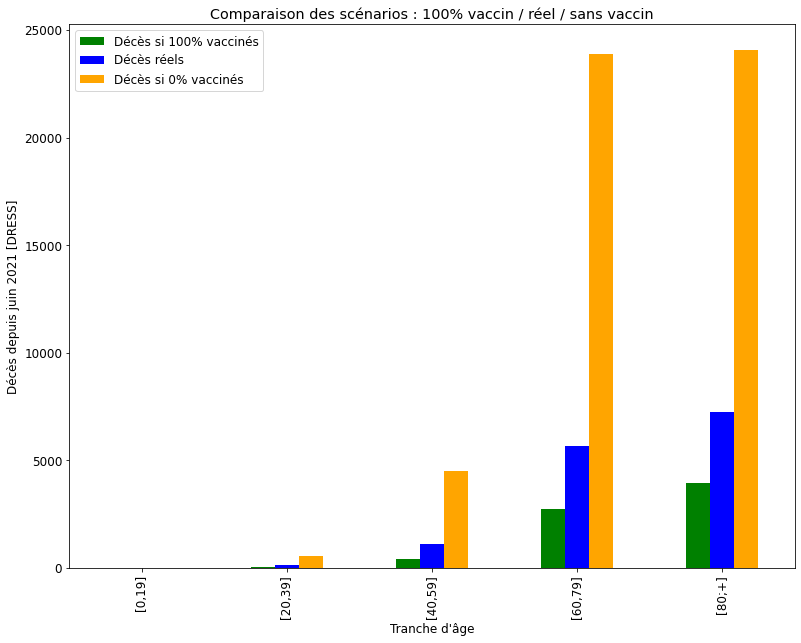

In [14]:
somme[["dc_100", "dc_all", "dc_0"]].plot.bar(
    title="Comparaison des scénarios : 100% vaccin / réel / sans vaccin",
    ylabel="Décès depuis juin 2021 [DRESS]",
    xlabel="Tranche d'âge",
    color=["green", "blue", "orange"])
plt.legend(["Décès si 100% vaccinés", "Décès réels" , "Décès si 0% vaccinés"])

# Tableau récapitulatif

In [15]:
summary = somme.append(somme.sum().rename('Total'))
summary.at["Total", "eff_vax"] = 0
summary[["dc_non_vax_1m", "dc_vax_1m", "dc_0", "dc_100", "saved", "to_save", "eff_vax"]].rename(columns={
    "dc_non_vax_1m" : "Décès chez les non-vaccinés pour 1M d'individus", 
    "dc_vax_1m" : "Décès chez les vaccinés pour 1M d'individus",
    "eff_vax": "Efficacité du vaccin (%)",
    "dc_0" : "Décès si 0% de la population est vaccinée", 
    "dc_100" : "Décès si 100% de la population est vaccinée",
    "saved" : "Décès évités", 
    "to_save" : "Décès évitables", 
})

vac_statut,Décès chez les non-vaccinés pour 1M d'individus,Décès chez les vaccinés pour 1M d'individus,Décès si 0% de la population est vaccinée,Décès si 100% de la population est vaccinée,Décès évités,Décès évitables,Efficacité du vaccin (%)
age,,,,,,,
"[0,19]",1,0,24,12,2,9,66
"[20,39]",35,3,559,52,395,111,91
"[40,59]",260,23,4513,411,3401,699,91
"[60,79]",1730,198,23884,2737,18195,2951,89
[80;+],6285,1031,24066,3947,16788,3330,85
Total,8311,1255,53046,7159,38781,7100,0
